# Telco Churn Report

## Acquire

### First lets bring in our libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import acquire #Contians function that get the telco data
#Tells pandas to show all columns when displaying the DataFrame
pd.set_option('display.max_columns', None)
# Change some matplotlib setting so plots look better
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)

### Now let's bring get the telco data and take a peek at it

In [2]:
telco = acquire.get_telco_data()
telco

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.90,542.4,No,Month-to-month,DSL,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,No,No,Yes,Yes,Yes,1,Yes,4,69.40,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,No,No,No,No,No,1,Yes,1,48.20,340.35,No,Month-to-month,DSL,Electronic check
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,No,No,No,No,No,1,Yes,1,25.10,25.1,Yes,Month-to-month,DSL,Electronic check
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,No,No,No,No,No,1,No,3,30.50,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9950-MTGYX,Male,0,Yes,Yes,28,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,20.30,487.95,No,Two year,None,Credit card (automatic)
7039,9953-ZMKSM,Male,0,No,No,63,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,No,2,25.25,1559.3,No,Two year,None,Mailed check
7040,9964-WBQDJ,Female,0,Yes,No,71,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,24.40,1725.4,No,Two year,None,Credit card (automatic)
7041,9972-EWRJS,Female,0,Yes,Yes,67,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,3,19.25,1372.9,No,Two year,None,Bank transfer (automatic)


In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
internet_service_type_id    7043 non-null int64
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
contract_type_id            7043 non-null int64
paperless_billing           7043 non-null object
payment_type_id             7043 non-null int64
monthly_charges 

* Takeaways
    * `total_charges` is an object so we will have to see if there is a string value that caused it to become an object.
    * Several of these variables are string so we will need to find away to convert them to ints so that we can use them in modeling.
    * There appears to be no null values but we will have to dig into the columns to make sure that this is true

### Let's look at the `total_charges` and see if there is a string that is causing an issue

In [4]:
telco.total_charges.value_counts()

           11
20.2       11
19.75       9
20.05       8
19.65       8
           ..
3247.55     1
5460.2      1
2215        1
6373.1      1
2326.05     1
Name: total_charges, Length: 6531, dtype: int64

There is a blank value for 11 of the values so we will need to make sure to change those in the preparation stage.

### Let's take a look at the distribution of tenure

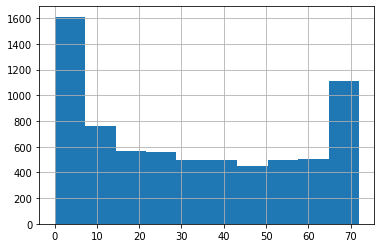

In [9]:
telco.tenure.hist()

We can see that our most common tenures are our lowest months and highest months.

# Preparation